# TASK 4: Machine Learning Implementation & Evaluation 
## Predicting Forest Type 

### Final Project, Python for Data Science 
#### Willamette University MSDS 
by Charles Hanks, Carter McMahon, & Cleighton Roberts 

<br>
<br>
<br>

### Table of Contents: 

4.0 Data Preparation <br> 
4.1 Random Forest Classifier <br>
4.2 Support Vector Machine Classifier <br>
4.3 RF vs. SVM Comparison <br>
4.4 Unsupervised Learning: Clustering <br>
4.5 Additional ML techniques <br>

## 4.0 Data Preparation

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score,cohen_kappa_score, roc_auc_score, roc_curve, classification_report, balanced_accuracy_score
from scipy.stats import loguniform, randint
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Loading the dataset: 

In [14]:
ds = pd.read_csv('data/covtype.csv')

Data Preprocessing - center and scaling: 

In [15]:
scale = StandardScaler()

ds.columns.get_loc('Cover_Type') # finding index of dependent variable 

numerical_features = ds.iloc[:,0:10] # subsetting numerical features we want to scale
scaled_num_features =  pd.DataFrame(scale.fit_transform(numerical_features), columns = numerical_features.columns)

ds = pd.concat([scaled_num_features, ds.iloc[:,10:]], axis = 1) #combining scaled numerical features with other variables

Initial Train/Test Split: 

In [72]:

X = ds.drop(ds.columns[-1], axis = 1)
y = ds[ds.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 650, test_size = 0.3)

## 4.1 Random Forest Classifier 

### Baseline model

In [17]:
rf = RandomForestClassifier(random_state=650)

In [18]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=650)

In [19]:
rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))
print(balanced_accuracy_score(rf_pred, y_test))
print(cohen_kappa_score(rf_pred, y_test))

# Accuracy: 0.952009133467964
# Balanced acc.: 0.9402627427863057
# Kappa: 0.9225107895423049

0.952009133467964
0.9402627427863057
0.9225107895423049


### Hyperparameter tuning with GridSearchCV

In [ ]:
param_grid = {
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [250]
}

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3, 
                           verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

# {'bootstrap': True,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 250}

In [ ]:
best_rf = grid_search.best_estimator_

In [ ]:
best_rf_pred = best_rf.predict(X_test)

print(accuracy_score(best_rf_pred, y_test))
print(balanced_accuracy_score(best_rf_pred, y_test))
print(cohen_kappa_score(best_rf_pred, y_test))

# Accuracy: 0.9525254727372866
# Balanced acc.: 0.9417587733036588
# Kappa: 0.9233291692648075

## 4.2 Support Vector Machine Classifier

### Baseline Model

The training this data using the standard SVC() function  takes an exceedingly long time. Per the [sci-kit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):

*"For large datasets consider using LinearSVC or SGDClassifier instead, possibly after a Nystroem transformer or other Kernel Approximation"*

In [9]:
model_lsvc = LinearSVC(random_state = 650)
model_lsvc.fit(X_train,y_train) 

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=650)

In [10]:
#predicting forest type on test data using first linear SVC model:  
lsvc_predict = model_lsvc.predict(X_test)

#print accuracy score: 
print(accuracy_score(lsvc_predict, y_test))
# accuracy = .71


0.7115958325683863


In [11]:
print(cohen_kappa_score(lsvc_predict, y_test))

0.5249588131713108


In [12]:
model_lsvc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 650,
 'tol': 0.0001,
 'verbose': 0}

### Hyperparameter Tuning with RandomizedSearchCV 
We are using RandomizezdSearchCV over GridSearchCV due to size of dataset and limit of computational power. 

In [ ]:
param_dist = {
    'C': loguniform(.0001, 10000),  #choosing a wide range for C 
    'max_iter': randint(1000, 5000) # randomly sampling between 1000 and 5000
}

n_iter_search = 5
random_search = RandomizedSearchCV(model_lsvc, 
                                   param_distributions = param_dist, 
                                   n_iter = n_iter_search, 
                                   n_jobs =4, 
                                   cv = 3, 
                                   random_state = 650)

In [ ]:
random_search.fit(X_train, y_train)     # note - this took 156 minutes to run

In [20]:
random_search.best_params_ # C=14.367136335397122, max_iter=1902

In [25]:
bp_c = 14.367136335397122 
bp_mi = 1902

In [26]:
best_lsvc = LinearSVC(C = bp_c, 
                      max_iter = bp_mi, 
                      random_state = 650)

In [27]:
best_lsvc.fit(X_train,y_train)


/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=14.367136335397122, max_iter=1902, random_state=650)

In [28]:
#predicting forest type on test data using first linear SVC model:  
lsvc_predict2 = best_lsvc.predict(X_test)

In [29]:
print(accuracy_score(lsvc_predict2, y_test)) #this randomized grid search produced results that were comparable to default hp settings. 
# the search space might not have included the best values. 

# accuracy = .71

0.7113950339636497


The random grid search did not significantly improve accuracy of our SVM model. 

## 4.4 Clustering 

In [30]:
comb_train = pd.concat([X_train, y_train],axis=1)
comb_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
2028,1.498778,1.111064,-0.414477,0.651952,-0.744810,0.452045,-0.789920,0.894409,1.240297,-0.053082,...,0,0,0,0,0,0,0,1,0,1
84405,-0.165600,-0.506255,-0.548020,0.233225,-0.641886,1.389032,0.891075,0.186218,-0.562470,2.285699,...,0,0,0,0,0,0,0,0,0,2
405118,0.538011,1.200419,-0.548020,-0.820649,-0.710502,-0.467625,-0.715209,0.793239,1.109662,-0.846773,...,0,0,0,0,0,0,0,0,0,1
559651,-1.383524,-0.747512,-0.280934,-0.561885,-0.761964,0.252591,0.779008,-0.319633,-0.719233,0.427965,...,0,0,0,0,0,0,0,0,0,2
497435,0.566584,-1.390866,1.054494,-0.867697,-0.418883,-0.781237,-1.126119,-1.533674,0.038452,-0.676858,...,0,0,0,0,0,0,0,0,0,1


In [33]:
#we want to run PCA on the whole model so that we can make a scree plot and determine how many components are viable


pca=PCA()
pc=pca.fit_transform(comb_train)

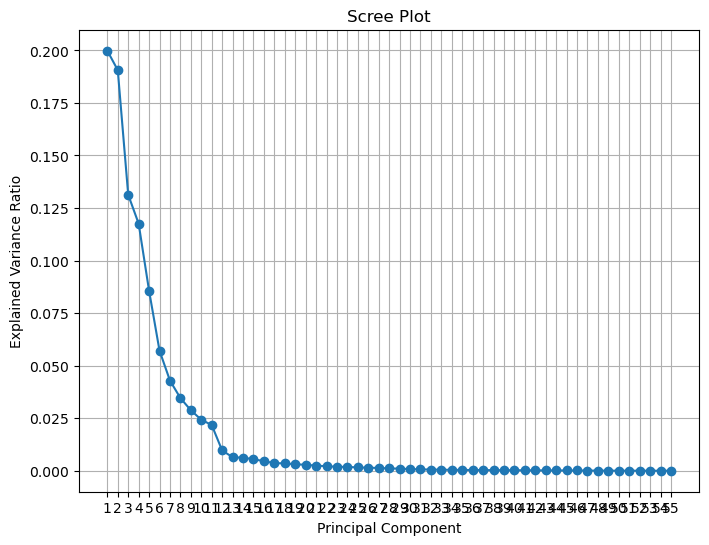

In [34]:
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

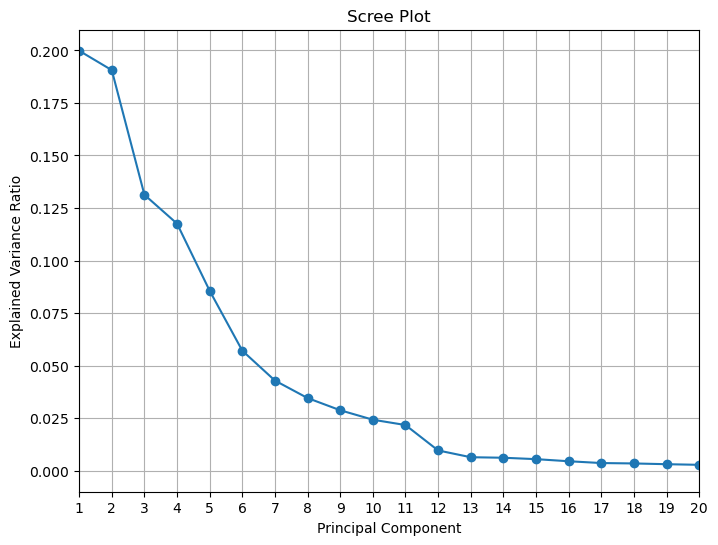

In [35]:
#zooming in
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.xlim(1, 20)
plt.show()

In [36]:
# this was a tough decision but I think I will go to 7
pca = PCA(n_components=7)

pca.fit(comb_train)
scores_pca = pca.transform(comb_train)

loadings_df = pd.DataFrame(pca.components_, columns=comb_train.columns)

print(loadings_df)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0  -0.341748 -0.179963  0.340054                         -0.087159   
1  -0.109821  0.477055  0.159258                          0.070199   
2   0.277417 -0.063299  0.270088                          0.587008   
3   0.194195 -0.056547 -0.312410                          0.285831   
4  -0.060381  0.080196  0.331299                         -0.165928   
5   0.598615  0.076040  0.189310                         -0.207156   
6   0.514977  0.120312  0.083785                         -0.055747   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.074791                        -0.319708   
1                        0.170437                        -0.107198   
2                        0.604989                         0.037138   
3                        0.147906                         0.247564   
4                       -0.058772                         0.491433   
5                  

In [39]:
kpca = KMeans(n_clusters=3,
             init = "k-means++",
             random_state=650)

#apply to da model

kpca.fit(scores_pca)

kpca_x = pd.concat([X_train.reset_index(drop=True),pd.DataFrame(scores_pca)], axis = 1) 
kpca_x['cluster #'] = kpca.labels_

pd.set_option('display.max_columns', None) 
kpca_x.head()

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,0,1,2,3,4,5,6,cluster #
0,1.498778,1.111064,-0.414477,0.651952,-0.744810,0.452045,-0.789920,0.894409,1.240297,-0.053082,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-2.521873,0.997659,0.050581,-0.090349,0.026769,0.713122,0.461294,2
1,-0.165600,-0.506255,-0.548020,0.233225,-0.641886,1.389032,0.891075,0.186218,-0.562470,2.285699,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.930480,-1.827853,-0.419103,1.203952,1.576399,-0.921921,0.081164,0
2,0.538011,1.200419,-0.548020,-0.820649,-0.710502,-0.467625,-0.715209,0.793239,1.109662,-0.846773,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.497722,1.340124,-1.040033,-1.158822,-1.026299,0.644688,0.508022,2
3,-1.383524,-0.747512,-0.280934,-0.561885,-0.761964,0.252591,0.779008,-0.319633,-0.719233,0.427965,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.785134,-1.265576,-1.005752,-0.252560,0.069204,-0.651266,-0.367436,0
4,0.566584,-1.390866,1.054494,-0.867697,-0.418883,-0.781237,-1.126119,-1.533674,0.038452,-0.676858,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.825191,-0.298890,0.437168,-2.251138,0.130923,0.953454,0.789648,0


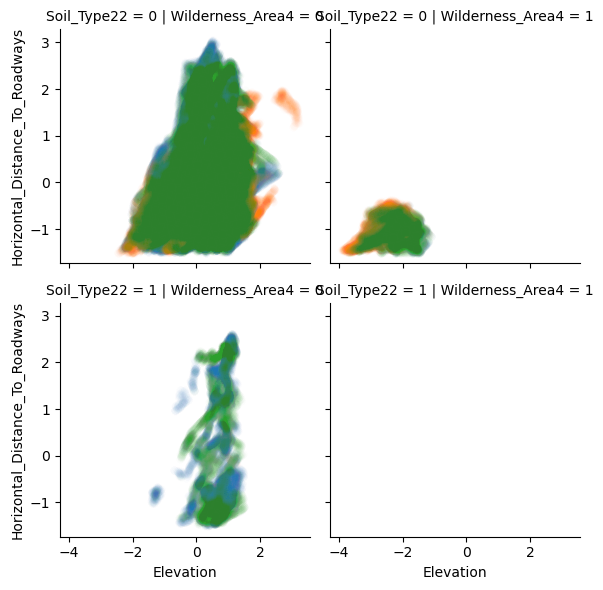

In [40]:
#now lets visualize4

g = sns.FacetGrid(kpca_x, col="Wilderness_Area4",row="Soil_Type22",hue="cluster #")
g.map(sns.scatterplot, "Elevation", 'Horizontal_Distance_To_Roadways'
      ,alpha=.01
     )

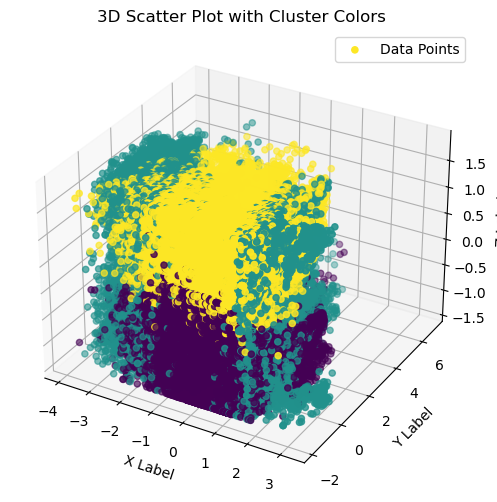

In [41]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for plotting
x, y, z = kpca_x.iloc[:, 0], kpca_x.iloc[:, 2], kpca_x.iloc[:, 1]

# Plot the data with color based on the "cluster" column
ax.scatter(x, y, z, c=kpca_x['cluster #'], cmap='viridis', marker='o', label='Data Points')

# Set axis labels and plot title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot with Cluster Colors')

# Show the color bar for the cluster labels
#plt.colorbar(label='cluster #')

# Show the plot
plt.legend()
plt.show()

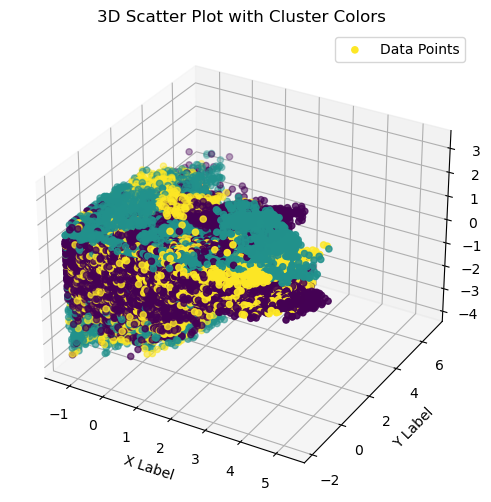

In [42]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for plotting
x, z, y  = kpca_x.iloc[:, 3], kpca_x["Elevation"], kpca_x["Slope"]

# Plot the data with color based on the "cluster" column
ax.scatter(x, y, z, c=kpca_x['cluster #'], cmap='viridis', marker='o', label='Data Points')

# Set axis labels and plot title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot with Cluster Colors')

# Show the color bar for the cluster labels
#plt.colorbar(label='cluster #')

# Show the plot
plt.legend()
plt.show()

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


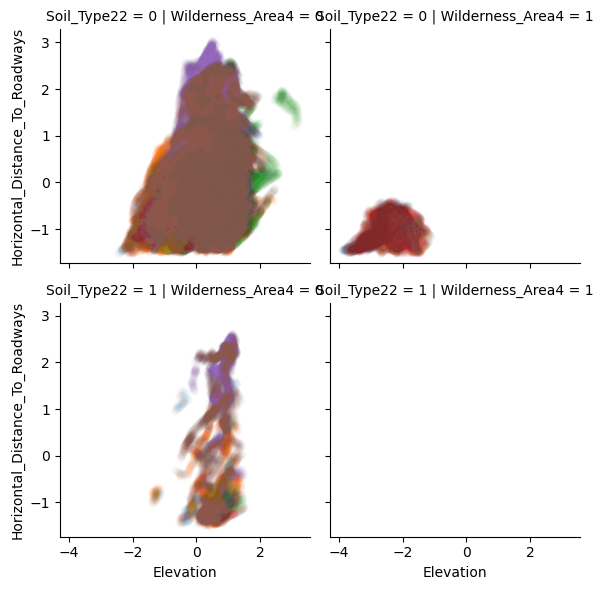

In [43]:
#repeat this all again but without forest type

pca = PCA(n_components=12)

pca.fit(X_train)
scores_pca = pca.transform(X_train)

kpca = KMeans(n_clusters=6,
             init = "k-means++",
             random_state=650)

#apply to da model

kpca.fit(scores_pca)

kpca_x = pd.concat([X_train.reset_index(drop=True),pd.DataFrame(scores_pca)], axis = 1) 
kpca_x['cluster #'] = kpca.labels_

pd.set_option('display.max_columns', None) 
kpca_x.head()

g = sns.FacetGrid(kpca_x, col="Wilderness_Area4",row="Soil_Type22",hue="cluster #")
g.map(sns.scatterplot, "Elevation", 'Horizontal_Distance_To_Roadways'
      ,alpha=.01
     )


#really this looks like 3 is the best, I can't really differentiate two of them but whatever

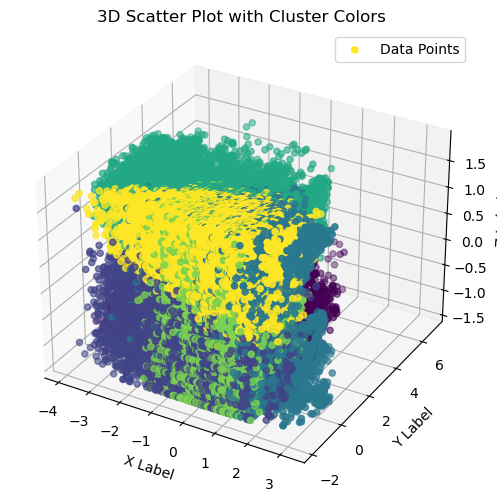

In [44]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for plotting
x, y, z = kpca_x.iloc[:, 0], kpca_x.iloc[:, 2], kpca_x.iloc[:, 1]

# Plot the data with color based on the "cluster" column
ax.scatter(x, y, z, c=kpca_x['cluster #'], cmap='viridis', marker='o', label='Data Points')

# Set axis labels and plot title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot with Cluster Colors')

# Show the color bar for the cluster labels
#plt.colorbar(label='cluster #')

# Show the plot
plt.legend()
plt.show()

## 4.5 Additional ML Techniques 

### KBest Feature Selection
Removing the features with the least impact on model performance

In [49]:
k_best_selector = SelectKBest(k = 30)
k_best_selector.fit(X = X, y = y)

SelectKBest(k=30)

In [50]:
#Looking at the top 30 features
print(X.columns[k_best_selector.get_support()])

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type10',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type17',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type35', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40'],
      dtype='object')


In [51]:

X_train_kbest = k_best_selector.fit_transform(X_train, y_train)
X_test_kbest = k_best_selector.transform(X_test)

In [52]:
#fitting SVM model using top 30 features
model_lsvc.fit(X_train_kbest, y_train)

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=650)

In [53]:
#predicting using top 30 features
lsvc_predict3 = model_lsvc.predict(X_test_kbest)

#print accuracy score: 
print(accuracy_score(lsvc_predict3, y_test))
#accuracy = .707, comparable to baseline model 

0.7069028823205434


Conclusion: Taking the top 30 features per KBest Feature Selection produces an equivalent accuracy to that produced by a model taking all variables. 

### Downsampling: 

This dataset is pretty heavily imbalanced, which is likely affecting our model's ability to differentiate between different tree types. Two common aproaches to handling an imbalanced dataset are downsampling and class weighting.



In [54]:
ds.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

As we can see, target classes 1 and 2 make up 495,141 of the rows, or 85% of the data. This is a good example of when accuracy is not a great measure of model performance. 49% of the data is class 2, which means if the model chose class 2 for every single prediction, it would still be correct half of the time. Accuracy can overestimate a model's performance for this reason. 

Cohen's Kappa is a better metric for evaluating models - it takes into account the agreement between what the model predict and the actual target labels, *adjusting for the agreement that could be expected by chance*. In this sense it is a weighted accuracy. 

kappa = (accuracy - random accuracy) / (1 - random accuracy)


Let's downsample each class to equalize how many of each class is present in our training and testing sets.  Like the name suggests, we are subdividing the data per each target class, and then sampling an equal number of observations from each class. In this case, we will randomly sample 2,747 rows from each class, because Cover Type 4 has the fewest observations (2747):

In [55]:
each_tree_type = []
for i in ds['Cover_Type'].unique():
    each_tree_type.append(ds[ds['Cover_Type'] == i]) #now each element in this list is a dataframe containing each class of tree


In [56]:
len(each_tree_type[6]) # index 6 of list each_tree_type has length 2747

2747

In [57]:
downsampled_trees = []

#downsampling each tree type data frame to match the size of the smallest class, Cover Type 4 with 2747 rows
for i in each_tree_type: 
    downsampled_trees.append(resample(i, replace = False, n_samples = len(each_tree_type[6]), random_state = 650))

In [58]:
#now we need to transform this list of data frames back into one dataframe: 
ds_dsamp = pd.concat(downsampled_trees)

ds_dsamp = ds_dsamp.sample(frac = 1, random_state = 650)

In [59]:
#confirming that we now have a balanced dataset: 
ds_dsamp.Cover_Type.value_counts()

1    2747
7    2747
2    2747
4    2747
3    2747
5    2747
6    2747
Name: Cover_Type, dtype: int64

Now we have a balanced dataset. We hypothesize that the model peformance will weaken now that each class has the same proportion of the training and test data (and train time will decrease due to the considerably smaller dataset). 

Train/Test Split with downsampled dataset: 

In [70]:
X_dsamp = ds_dsamp.drop(ds_dsamp.columns[-1], axis = 1)
y_dsamp = ds_dsamp[ds_dsamp.columns[-1]]

X_train_dsamp, X_test_dsamp, y_train_dsamp, y_test_dsamp = train_test_split(X_dsamp,y_dsamp, random_state = 650, test_size = 0.3)

#### Support Vector Machine

In [71]:
model_lsvc.fit(X_train_dsamp,y_train_dsamp) 

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=650)

In [74]:

lsvc_predict = model_lsvc.predict(X_test_dsamp)

print(accuracy_score(lsvc_predict, y_test_dsamp))

0.6763737216155313


In [75]:
print(cohen_kappa_score(lsvc_predict, y_test_dsamp))

0.622345392551398


As you can see, the kappa of our model trained on balanced dataset is .62, whereas the original model's kappa was .52. 

#### Random Forest

In [76]:
rf = RandomForestClassifier(random_state=650,
                            n_estimators=250)

In [77]:
rf.fit(X_train_dsamp, y_train_dsamp)

RandomForestClassifier(n_estimators=250, random_state=650)

In [83]:
#predicting RF model trained on equalized dataset on holdout X test (imbalanced)
rf_eq_pred = rf.predict(X_test)

In [84]:
print(accuracy_score(rf_eq_pred, y_test))
print(balanced_accuracy_score(rf_eq_pred, y_test))
print(cohen_kappa_score(rf_eq_pred, y_test))

# The model trained on downsampled data
# Accuracy: 0.7513080594822839
# Balanced acc.: 0.6232433828611598
# Kappa: 0.6259294958340503

# vs

# The model trained on the whole dataset
# Accuracy: 0.952009133467964
# Balanced acc.: 0.9402627427863057
# Kappa: 0.9225107895423049

0.7513080594822839
0.6232433828611598
0.6259294958340503


In [85]:
imbal_conf = confusion_matrix(rf_pred, y_test)
imbal_conf = confusion_matrix(rf_pred, y_test)
eq_conf = confusion_matrix(rf_eq_pred, y_test)

print('Imbalanced classes model \n')
print(imbal_conf, '\n\n\n')
print('Equalized classes model \n')
print(eq_conf)

# Imbalanced classes model 
# 
# [[59860  2002     3     0    31     5   283]
#  [ 3621 82704   164     0   581   150    41]
#  [    2   163 10254    90    26   399     0]
#  [    0     2    49   695     0    26     0]
#  [   24   106     8     0  2164     1     0]
#  [    7   104   196    24    14  4587     0]
#  [  122    31     0     0     0     0  5765]] 

# Equalized classes model 

# [[49090 15385     0     0     3     0   196]
#  [ 9131 59027    54     0    64    20     2]
#  [   23  1811  8883     4    35   428     0]
#  [    0    45   476   805     0   122     0]
#  [ 1261  6026    82     0  2697    33     2]
#  [  183  2320  1179     0    17  4565     0]
#  [ 3948   498     0     0     0     0  5889]]

Imbalanced classes model 

[[59881  2091     1     0    29     6   294]
 [ 3582 82615   172     0   576   145    39]
 [    3   166 10237    82    27   410     0]
 [    0     2    52   701     0    27     0]
 [   24   106    10     0  2171     2     0]
 [   10    99   202    26    13  4578     0]
 [  136    33     0     0     0     0  5756]] 



Equalized classes model 

[[49090 15385     0     0     3     0   196]
 [ 9131 59027    54     0    64    20     2]
 [   23  1811  8883     4    35   428     0]
 [    0    45   476   805     0   122     0]
 [ 1261  6026    82     0  2697    33     2]
 [  183  2320  1179     0    17  4565     0]
 [ 3948   498     0     0     0     0  5889]]


### GridSearchCV with Downsampled Dataset

#### Support Vector Machine

Given how much quicker our downsampled dataset is to train a model, let's return to the GridSearchCV technique in hopes of getting better hyperparamter tuning. GridSearchCV is exhaustive, having a larger search space than RandomizedSearchCV.

In [43]:
param_grid = {
    'C': [3,6,9,12,15,18,21],          
    'max_iter': [500,1000,2000,4000]  
}

In [44]:
grid_search_dsamp = GridSearchCV(model_lsvc, param_grid=param_grid, cv=5)
grid_search_dsamp.fit(X_train, y_train)

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Convergenc

GridSearchCV(cv=5, estimator=LinearSVC(random_state=650),
             param_grid={'C': [3, 6, 9, 12, 15, 18, 21],
                         'max_iter': [500, 1000, 2000, 4000]})

In [45]:
grid_search_dsamp.best_params_

{'C': 9, 'max_iter': 2000}

In [47]:
best_lsvc_dsamp = LinearSVC(C = grid_search_dsamp.best_params_['C'], 
                      max_iter = grid_search_dsamp.best_params_['max_iter'], 
                      random_state = 650)

In [49]:
best_lsvc_dsamp.fit(X_train,y_train)

/Users/chanks/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=9, max_iter=2000, random_state=650)

In [51]:
best_lsvc_dsamp_predictions = best_lsvc_dsamp.predict(X_test)

In [52]:
print(accuracy_score(best_lsvc_dsamp_predictions, y_test))

0.6762003813485873


In [53]:
print(cohen_kappa_score(best_lsvc_dsamp_predictions, y_test))

0.6221482409289651


Despite these efforts to improve our SVM model performance, the hyperparamter tuning has had little effect. 

### K-Nearest Neighbors 

Train/test split:


In [88]:
X = ds.drop(ds.columns[-1], axis = 1)
y = ds[ds.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 650, test_size = 0.3)

In [89]:
knn = KNeighborsClassifier(n_neighbors=5)


KNN train: 

In [90]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

KNN prediction: 

In [91]:
knn_predictions = knn.predict(X_test)

In [92]:
print(accuracy_score(knn_predictions, y_test))

0.9249242702404994


In [93]:
confusion_matrix(knn_predictions, y_test)

array([[58608,  3794,     6,     0,    78,    17,   359],
       [ 4643, 80364,   330,     1,   532,   283,    52],
       [    7,   288,  9666,   146,    36,   693,     0],
       [    0,     0,    89,   618,     0,    34,     0],
       [   59,   359,    22,     0,  2153,     8,     2],
       [   13,   249,   561,    44,    17,  4133,     0],
       [  306,    58,     0,     0,     0,     0,  5676]])